In [1]:
# Cell 1: Setup (imports, installs, paths)

import os
import re
import json
import math
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

# ---------- pip installs (run once) ----------
# If already installed, it will be quick.
import sys
!{sys.executable} -m pip -q install fredapi xgboost shap statsmodels openpyxl requests

import statsmodels.api as sm
from fredapi import Fred
import shap
from xgboost import XGBRegressor
import requests

# ---------- output directory ----------
OUTPUTS = Path.cwd() / "outputs"
OUTPUTS.mkdir(parents=True, exist_ok=True)

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 200)

print("OUTPUTS dir:", OUTPUTS)



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


OUTPUTS dir: c:\Users\starw\.vscode\practice\outputs


In [2]:
# Cell 2: Config

USMPD_XLSX_PATH = r"C:\Users\starw\Downloads\USMPD.xlsx"   # <-- 너 파일 경로
FRED_API_KEY = "84e5755cb4a75b80cc8cd2a9edf30474"             # <-- 여기에 붙여넣기 (따옴표 포함)

START_DATE = "2010-01-01"
END_DATE   = None  # None이면 최신까지

# FRED series IDs
SERIES = {
    "VIX": "VIXCLS",          # Cboe VIX via FRED
    "EPU": "USEPUINDXD",      # US Economic Policy Uncertainty index
    "DGS2": "DGS2",           # 2y treasury
    "DGS10": "DGS10",         # 10y treasury
    "SP500": "SP500",         # S&P 500 index level
}

# ADS (Philadelphia Fed) CSV endpoint (works via internet)
ADS_URL = "https://www.philadelphiafed.org/-/media/frbp/assets/surveys-and-data/ads/ads-index.csv"

fred = Fred(api_key=FRED_API_KEY)

print("Config loaded.")


Config loaded.


In [9]:
# Cell 2.5: Inspect "Monetary Events" sheet
df_events = pd.read_excel(USMPD_XLSX_PATH, sheet_name="Monetary Events", engine="openpyxl")
print("Shape:", df_events.shape)
print("\nColumns:")
for i, c in enumerate(df_events.columns):
    print(f"  {i:2d}: {repr(c)}")
print("\nFirst 5 rows:")
display(df_events.head())

Shape: (273, 37)

Columns:
   0: 'Date'
   1: 'date_time'
   2: 'SEP'
   3: 'Unscheduled'
   4: 'PC'
   5: 'MP1'
   6: 'MP2'
   7: 'FF1'
   8: 'FF2'
   9: 'FF3'
  10: 'FF4'
  11: 'FF5'
  12: 'FF6'
  13: 'ED1'
  14: 'ED2'
  15: 'ED3'
  16: 'ED4'
  17: 'ED5'
  18: 'ED6'
  19: 'ED7'
  20: 'ED8'
  21: 'OIS1Y'
  22: 'OIS2Y'
  23: 'UST3M'
  24: 'UST6M'
  25: 'UST2Y'
  26: 'UST5Y'
  27: 'UST10Y'
  28: 'UST30Y'
  29: 'TIPS5Y'
  30: 'TIPS10Y'
  31: 'TIPS30Y'
  32: 'SP500'
  33: 'SPFUT'
  34: 'DXY'
  35: 'EURUSD'
  36: 'USDJPY'

First 5 rows:


,Date,date_time,SEP,Unscheduled,PC,MP1,MP2,FF1,FF2,FF3,FF4,FF5,FF6,ED1,ED2,ED3,ED4,ED5,ED6,ED7,ED8,OIS1Y,OIS2Y,UST3M,UST6M,UST2Y,UST5Y,UST10Y,UST30Y,TIPS5Y,TIPS10Y,TIPS30Y,SP500,SPFUT,DXY,EURUSD,USDJPY
0,1994-02-04,1994-02-04 11:05:00,0,0,0,0.163333,-0.054780,0.14000,0.10001,0.08,0.00,0.00,0.0,0.130,0.15,0.140,0.15,0.13,0.13,0.13,0.13,NaN,NaN,0.149,NaN,0.142,0.112,0.074,0.016,NaN,NaN,NaN,NaN,NaN,0.865304,NaN,NaN
1,1994-03-22,1994-03-22 14:20:00,0,0,0,0.000000,-0.088571,0.00000,-0.04000,-0.04,0.00,0.00,0.0,-0.050,-0.05,-0.030,-0.04,-0.05,-0.05,-0.05,-0.05,NaN,NaN,-0.021,NaN,-0.052,-0.073,-0.066,-0.051,NaN,NaN,NaN,NaN,NaN,0.227273,NaN,NaN
2,1994-04-18,1994-04-18 10:06:00,0,1,0,0.150025,-0.005030,0.06001,0.08000,0.09,0.12,0.00,0.0,0.080,0.09,0.080,0.11,0.07,0.08,0.08,0.07,NaN,NaN,0.145,NaN,0.125,0.111,0.084,0.032,NaN,NaN,NaN,NaN,NaN,0.315823,NaN,NaN
3,1994-05-17,1994-05-17 14:26:00,0,0,0,0.110714,-0.051371,0.05000,0.05000,-0.02,0.05,-0.05,0.0,-0.040,-0.06,-0.070,-0.07,-0.11,-0.10,-0.11,-0.11,NaN,NaN,0.036,NaN,-0.060,-0.091,-0.100,-0.088,NaN,NaN,NaN,NaN,NaN,0.225491,NaN,NaN
4,1994-07-06,1994-07-06 14:18:00,0,0,0,-0.049600,0.052907,-0.04000,0.00000,0.00,0.00,0.00,0.0,-0.015,-0.01,-0.005,-0.01,0.01,0.01,0.00,0.00,NaN,NaN,-0.010,NaN,0.004,0.013,0.018,0.018,NaN,NaN,NaN,NaN,NaN,-0.055822,NaN,NaN


In [10]:
# Cell 3: Load USMPD Excel and map columns robustly

def _normalize_col(s: str) -> str:
    s = str(s).strip().lower()
    s = re.sub(r"\s+", "_", s)
    s = re.sub(r"[^a-z0-9_]", "", s)
    return s

def find_col(df, candidates):
    cols = list(df.columns)
    norm_map = {_normalize_col(c): c for c in cols}
    for cand in candidates:
        cand_norm = _normalize_col(cand)
        if cand_norm in norm_map:
            return norm_map[cand_norm]
    # fallback: partial match
    for cand in candidates:
        cand_norm = _normalize_col(cand)
        for k, orig in norm_map.items():
            if cand_norm in k:
                return orig
    return None

# Load from the correct sheet: "Monetary Events"
raw = pd.read_excel(USMPD_XLSX_PATH, sheet_name="Monetary Events", engine="openpyxl")
df = raw.copy()

print("Loaded USMPD shape:", df.shape)
print("First 10 columns:", list(df.columns)[:10])

# Find date column (now includes "Date" with capital D)
date_col = find_col(df, ["Date", "date", "dt", "trading_date", "event_date", "mapped_trading_date", "mapped_date"])
if date_col is None:
    raise ValueError("Could not find a date column. Please print df.columns and share with me.")

df[date_col] = pd.to_datetime(df[date_col])
df = df.sort_values(date_col).reset_index(drop=True)

# Map required columns (best-effort)
col_map = {}

col_map["surp_target"]     = find_col(df, ["MP1", "surp_target", "mp1", "target_surprise", "mp1_surprise"])
col_map["surp_path_next"]  = find_col(df, ["MP2", "surp_path_next", "mp2", "path_surprise", "mp2_surprise", "pathnext"])
col_map["surp_path_ffavg"] = find_col(df, ["surp_path_ffavg", "path_ffavg", "ffavg", "path_avg", "surp_path_avg"])

col_map["is_event"]     = find_col(df, ["is_event", "event", "fomc", "event_day"])
col_map["Unscheduled"]  = find_col(df, ["Unscheduled", "unscheduled", "is_unscheduled"])
col_map["PC"]           = find_col(df, ["PC", "press_conference", "pressconf"])
col_map["SEP"]          = find_col(df, ["SEP", "sep_release", "economic_projections"])

# Print mapping status
print("\nColumn mapping:")
for k, v in col_map.items():
    print(f"  {k:15s} -> {v}")

missing = [k for k,v in col_map.items() if v is None and k in ["surp_target","surp_path_next"]]
if missing:
    raise ValueError(f"Missing critical columns: {missing}. Please share df.columns with me.")

# Build event_frame with standardized column names
event = pd.DataFrame({
    "date": df[date_col],
    "surp_target": df[col_map["surp_target"]],
    "surp_path_next": df[col_map["surp_path_next"]],
})

if col_map["surp_path_ffavg"] is not None:
    event["surp_path_ffavg"] = df[col_map["surp_path_ffavg"]]
else:
    # if absent, create as NaN (robustness will be skipped gracefully)
    event["surp_path_ffavg"] = np.nan

# event indicators (default safe)
event["is_event"] = 1
if col_map["is_event"] is not None:
    event["is_event"] = df[col_map["is_event"]].astype(float).fillna(0).astype(int)

for k in ["Unscheduled","PC","SEP"]:
    if col_map[k] is not None:
        event[k] = df[col_map[k]].astype(float).fillna(0).astype(int)
    else:
        event[k] = 0

# Ensure numeric
for c in ["surp_target","surp_path_next","surp_path_ffavg"]:
    event[c] = pd.to_numeric(event[c], errors="coerce")

event = event.sort_values("date").reset_index(drop=True)

print("\nEvent head:")
display(event.head())
print("\nEvent counts:", event["is_event"].value_counts().to_dict())

Loaded USMPD shape: (273, 37)
First 10 columns: ['Date', 'date_time', 'SEP', 'Unscheduled', 'PC', 'MP1', 'MP2', 'FF1', 'FF2', 'FF3']

Column mapping:
  surp_target     -> MP1
  surp_path_next  -> MP2
  surp_path_ffavg -> None
  is_event        -> None
  Unscheduled     -> Unscheduled
  PC              -> PC
  SEP             -> SEP

Event head:


,date,surp_target,surp_path_next,surp_path_ffavg,is_event,Unscheduled,PC,SEP
0,1994-02-04,0.163333,-0.054780,NaN,1,0,0,0
1,1994-03-22,0.000000,-0.088571,NaN,1,0,0,0
2,1994-04-18,0.150025,-0.005030,NaN,1,1,0,0
3,1994-05-17,0.110714,-0.051371,NaN,1,0,0,0
4,1994-07-06,-0.049600,0.052907,NaN,1,0,0,0



Event counts: {1: 273}


In [11]:
# Cell 4: Pull data from FRED

def get_fred_series(series_id, name):
    s = fred.get_series(series_id)
    s = pd.Series(s, name=name)
    s.index = pd.to_datetime(s.index)
    return s

vix   = get_fred_series(SERIES["VIX"], "VIX")
epu   = get_fred_series(SERIES["EPU"], "EPU")
dgs2  = get_fred_series(SERIES["DGS2"], "DGS2")
dgs10 = get_fred_series(SERIES["DGS10"], "DGS10")
sp500 = get_fred_series(SERIES["SP500"], "SP500")

# Merge into daily frame
macro = pd.concat([vix, epu, dgs2, dgs10, sp500], axis=1).sort_index()

# Date filter
if START_DATE:
    macro = macro.loc[macro.index >= pd.to_datetime(START_DATE)]
if END_DATE:
    macro = macro.loc[macro.index <= pd.to_datetime(END_DATE)]

# Basic transforms
macro["term_slope"] = macro["DGS10"] - macro["DGS2"]
macro["sp_ret"] = np.log(macro["SP500"]).diff()
macro["dlogVIX"] = np.log(macro["VIX"]).diff()

print("Macro shape:", macro.shape)
display(macro.tail())


Macro shape: (5841, 8)


,VIX,EPU,DGS2,DGS10,SP500,term_slope,sp_ret,dlogVIX
2025-12-24,13.47,222.05,3.47,4.15,6932.05,0.68,0.003216,-0.038592
2025-12-25,NaN,200.28,NaN,NaN,NaN,NaN,NaN,NaN
2025-12-26,13.60,512.76,3.46,4.14,6929.94,0.68,NaN,NaN
2025-12-27,NaN,310.47,NaN,NaN,NaN,NaN,NaN,NaN
2025-12-28,NaN,545.73,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
# Cell 5: Pull ADS index (skip if not available)

# Remove existing ADS column if present (from previous failed runs)
if "ADS" in macro.columns:
    macro = macro.drop(columns=["ADS"])

# Try multiple FRED series IDs for ADS
ads_series_ids = ["ADSBUSIN", "ADS", "ADSINDEX"]
ads = None

for sid in ads_series_ids:
    try:
        ads = fred.get_series(sid)
        ads = pd.Series(ads, name="ADS")
        ads.index = pd.to_datetime(ads.index)
        print(f"ADS loaded from FRED ({sid})")
        break
    except Exception as e:
        print(f"FRED {sid} not available: {e}")

if ads is None or len(ads) == 0:
    print("ADS not available from FRED. Skipping ADS feature.")
    macro["ADS"] = np.nan
else:
    # Merge ADS into macro
    macro = macro.join(ads, how="left")
    # Forward-fill for state variable usage
    macro["ADS"] = macro["ADS"].ffill()

print("\nADS status:")
print("  Non-null count:", macro["ADS"].notna().sum())
if macro["ADS"].notna().any():
    display(macro[["ADS"]].dropna().tail())
else:
    print("  (ADS column is all NaN - will be excluded from analysis)")

FRED ADSBUSIN not available: Bad Request.  The series does not exist.
FRED ADS not available: Bad Request.  The series does not exist.
FRED ADSINDEX not available: Bad Request.  The series does not exist.
ADS not available from FRED. Skipping ADS feature.

ADS status:
  Non-null count: 0
  (ADS column is all NaN - will be excluded from analysis)


In [16]:
# Cell 6: Build panel by merging event info into daily macro frame

panel = macro.copy()
panel = panel.reset_index().rename(columns={"index": "date"})

# Merge event data (left join)
panel = panel.merge(event, on="date", how="left")

# Fill non-event days safely
panel["is_event"] = panel["is_event"].fillna(0).astype(int)
for c in ["Unscheduled","PC","SEP"]:
    panel[c] = panel[c].fillna(0).astype(int)

for c in ["surp_target","surp_path_next","surp_path_ffavg"]:
    panel[c] = panel[c].fillna(0.0)

panel = panel.sort_values("date").set_index("date")

# Quick sanity checks
print("Panel shape:", panel.shape)
print("Event days:", int(panel["is_event"].sum()))
display(panel.head())


Panel shape: (5841, 16)
Event days: 135


,VIX,EPU,DGS2,DGS10,SP500,term_slope,sp_ret,dlogVIX,ADS,surp_target,surp_path_next,surp_path_ffavg,is_event,Unscheduled,PC,SEP
date,,,,,,,,,,,,,,,,
2010-01-01,NaN,174.55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0,0,0,0
2010-01-02,NaN,119.52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0,0,0,0
2010-01-03,NaN,216.95,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0,0,0,0
2010-01-04,20.04,150.35,1.09,3.85,NaN,2.76,NaN,NaN,NaN,0.0,0.0,0.0,0,0,0,0
2010-01-05,19.35,151.16,1.01,3.77,NaN,2.76,NaN,-0.035038,NaN,0.0,0.0,0.0,0,0,0,0


In [21]:
# Cell 7: Main regression + robust inference (studentized wild bootstrap + permutation)

# Build lag controls
for c in ["VIX", "dlogVIX", "EPU", "term_slope"]:
    panel[f"{c}_lag1"] = panel[c].shift(1)

# Only add ADS_lag1 if ADS has data
if panel["ADS"].notna().any():
    panel["ADS_lag1"] = panel["ADS"].shift(1)
    ads_available = True
else:
    ads_available = False
    print("Note: ADS not available, excluding from regression")

# Event-only sample with required fields
base_cols = [
    "dlogVIX", "is_event",
    "surp_target","surp_path_next",
    "Unscheduled","PC","SEP",
    "VIX_lag1","dlogVIX_lag1","EPU_lag1","term_slope_lag1",
    "sp_ret"
]
if ads_available:
    base_cols.append("ADS_lag1")

ev = panel.loc[panel["is_event"]==1, base_cols].dropna().copy()
print("Event sample N:", len(ev), " / period:", ev.index.min().date(), "to", ev.index.max().date())

y = ev["dlogVIX"]

# Build X_main based on available features
x_cols = [
    "surp_target", "surp_path_next",
    "Unscheduled","PC","SEP",
    "VIX_lag1","dlogVIX_lag1","EPU_lag1","term_slope_lag1"
]
if ads_available:
    x_cols.append("ADS_lag1")

X_main = ev[x_cols].copy()

def fit_hc1(y, X):
    Xc = sm.add_constant(X, has_constant="add")
    return sm.OLS(y, Xc).fit(cov_type="HC1")

m_main = fit_hc1(y, X_main)
print(m_main.summary())

# ---------- robust inference ----------
def studentized_wild_bootstrap_null(y, X, test_var, B=9999, seed=777):
    rng = np.random.default_rng(seed)
    m_full = fit_hc1(y, X)
    t_obs = float(m_full.tvalues[test_var])

    X_rest = X.drop(columns=[test_var])
    m_rest = fit_hc1(y, X_rest)

    yhat0 = m_rest.fittedvalues.values
    u0 = m_rest.resid.values

    t_star = np.empty(B)
    for b in range(B):
        w = rng.choice([-1.0, 1.0], size=len(y))
        y_star = yhat0 + u0 * w
        m_star = fit_hc1(y_star, X)
        t_star[b] = float(m_star.tvalues[test_var])

    p_val = float(np.mean(np.abs(t_star) >= abs(t_obs)))
    return t_obs, p_val

def studentized_wild_bootstrap_unrestricted(y, X, test_var, B=9999, seed=777):
    rng = np.random.default_rng(seed)
    m_full = fit_hc1(y, X)
    t_obs = float(m_full.tvalues[test_var])

    yhat = m_full.fittedvalues.values
    uhat = m_full.resid.values

    t_star = np.empty(B)
    for b in range(B):
        w = rng.choice([-1.0, 1.0], size=len(y))
        y_star = yhat + uhat * w
        m_star = fit_hc1(y_star, X)
        t_star[b] = float(m_star.tvalues[test_var])

    p_val = float(np.mean(np.abs(t_star) >= abs(t_obs)))
    return t_obs, p_val

def permutation_test_beta(y, X, test_var, B=5000, seed=777):
    rng = np.random.default_rng(seed)
    m_obs = fit_hc1(y, X)
    beta_obs = float(m_obs.params[test_var])

    beta_star = np.empty(B)
    for b in range(B):
        Xp = X.copy()
        Xp[test_var] = rng.permutation(Xp[test_var].values)
        m_star = fit_hc1(y, Xp)
        beta_star[b] = float(m_star.params[test_var])

    p_val = float(np.mean(np.abs(beta_star) >= abs(beta_obs)))
    return beta_obs, p_val

B_boot = 9999

# Path
t_path_null, p_path_null = studentized_wild_bootstrap_null(y, X_main, "surp_path_next", B=B_boot, seed=777)
t_path_unr,  p_path_unr  = studentized_wild_bootstrap_unrestricted(y, X_main, "surp_path_next", B=B_boot, seed=777)
beta_path_perm, p_path_perm = permutation_test_beta(y, X_main, "surp_path_next", B=5000, seed=777)

# Target
t_targ_null, p_targ_null = studentized_wild_bootstrap_null(y, X_main, "surp_target", B=B_boot, seed=777)
t_targ_unr,  p_targ_unr  = studentized_wild_bootstrap_unrestricted(y, X_main, "surp_target", B=B_boot, seed=777)
beta_targ_perm, p_targ_perm = permutation_test_beta(y, X_main, "surp_target", B=5000, seed=777)

robust_inf = pd.DataFrame([
    {"var":"surp_path_next", "HC1_t": float(m_main.tvalues["surp_path_next"]), "HC1_p": float(m_main.pvalues["surp_path_next"]),
     "WB_null_p": p_path_null, "WB_unrestricted_p": p_path_unr, "Perm_p": p_path_perm, "Perm_beta": beta_path_perm},
    {"var":"surp_target", "HC1_t": float(m_main.tvalues["surp_target"]), "HC1_p": float(m_main.pvalues["surp_target"]),
     "WB_null_p": p_targ_null, "WB_unrestricted_p": p_targ_unr, "Perm_p": p_targ_perm, "Perm_beta": beta_targ_perm},
])

print("\nRobust inference summary:")
display(robust_inf)

robust_inf.to_csv(OUTPUTS / "robust_inference_summary.csv", index=False)
print("Saved:", OUTPUTS / "robust_inference_summary.csv")

Note: ADS not available, excluding from regression
Event sample N: 82  / period: 2016-01-27 to 2025-12-10
                            OLS Regression Results                            
Dep. Variable:                dlogVIX   R-squared:                       0.146
Model:                            OLS   Adj. R-squared:                  0.039
Method:                 Least Squares   F-statistic:                     2.978
Date:                Tue, 30 Dec 2025   Prob (F-statistic):            0.00454
Time:                        09:08:12   Log-Likelihood:                 76.863
No. Observations:                  82   AIC:                            -133.7
Df Residuals:                      72   BIC:                            -109.7
Df Model:                           9                                         
Covariance Type:                  HC1                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
--------------------

,var,HC1_t,HC1_p,WB_null_p,WB_unrestricted_p,Perm_p,Perm_beta
0,surp_path_next,2.823328,0.004753,0.000200,0.533253,0.0032,1.448987
1,surp_target,-0.773567,0.439187,0.520352,0.595660,0.3046,-0.515973


Saved: c:\Users\starw\.vscode\practice\outputs\robust_inference_summary.csv


In [23]:
# Cell 8: Robustness regressions

def coef_table(model, keys):
    out = []
    for k in keys:
        if k in model.params.index:
            out.append({
                "var": k,
                "coef": float(model.params[k]),
                "se": float(model.bse[k]),
                "t": float(model.tvalues[k]),
                "p": float(model.pvalues[k]),
            })
    return pd.DataFrame(out)

# Build base control columns (same logic as Cell 7)
base_control_cols = ["VIX_lag1","dlogVIX_lag1","EPU_lag1","term_slope_lag1"]
if "ADS_lag1" in ev.columns:
    base_control_cols.append("ADS_lag1")

# Robust 1: Path FFavg (if available)
if "surp_path_ffavg" in panel.columns and panel.loc[panel["is_event"]==1, "surp_path_ffavg"].notna().any():
    # Need to rebuild ev with surp_path_ffavg included
    ffavg_cols = ["dlogVIX", "surp_target", "surp_path_ffavg", "Unscheduled","PC","SEP"] + base_control_cols
    ev_ff = panel.loc[panel["is_event"]==1, ffavg_cols].dropna().copy()
    if len(ev_ff) > 10 and ev_ff["surp_path_ffavg"].abs().sum() > 0:
        y_ff = ev_ff["dlogVIX"]
        X_ff = ev_ff[["surp_target", "surp_path_ffavg", "Unscheduled","PC","SEP"] + base_control_cols].copy()
        m_ff = fit_hc1(y_ff, X_ff)
        print("\nROBUST: target + path_ffavg")
        print(m_ff.summary())
        tbl_ff = coef_table(m_ff, ["surp_target","surp_path_ffavg"])
        tbl_ff.to_csv(OUTPUTS / "robust_path_ffavg_keycoef.csv", index=False)
    else:
        m_ff = None
        print("Insufficient data for surp_path_ffavg robustness -> skipping.")
else:
    m_ff = None
    print("No usable surp_path_ffavg in file -> skipping Robust FFavg.")

# Robust 2: add same-day sp_ret (bad control robustness only)
X_sp = X_main.copy()
X_sp["sp_ret_same"] = ev["sp_ret"]
m_sp = fit_hc1(y, X_sp)
print("\nROBUST (bad control): add same-day sp_ret")
print(m_sp.summary())
tbl_sp = coef_table(m_sp, ["surp_target","surp_path_next","sp_ret_same"])
tbl_sp.to_csv(OUTPUTS / "robust_add_spret_keycoef.csv", index=False)

# Robust 3: interactions with unscheduled
ev["target_x_unsched"] = ev["surp_target"] * ev["Unscheduled"]
ev["path_x_unsched"]   = ev["surp_path_next"] * ev["Unscheduled"]

X_int_cols = ["surp_target","surp_path_next","target_x_unsched","path_x_unsched","Unscheduled","PC","SEP"] + base_control_cols
X_int = ev[X_int_cols].copy()

m_int = fit_hc1(y, X_int)
print("\nROBUST: interactions (shock × Unscheduled)")
print(m_int.summary())
tbl_int = coef_table(m_int, ["surp_target","surp_path_next","target_x_unsched","path_x_unsched"])
tbl_int.to_csv(OUTPUTS / "robust_interaction_unsched_keycoef.csv", index=False)

print("\nSaved robustness tables in outputs/.")

Insufficient data for surp_path_ffavg robustness -> skipping.

ROBUST (bad control): add same-day sp_ret
                            OLS Regression Results                            
Dep. Variable:                dlogVIX   R-squared:                       0.545
Model:                            OLS   Adj. R-squared:                  0.481
Method:                 Least Squares   F-statistic:                     3.753
Date:                Tue, 30 Dec 2025   Prob (F-statistic):           0.000442
Time:                        09:09:28   Log-Likelihood:                 102.67
No. Observations:                  82   AIC:                            -183.3
Df Residuals:                      71   BIC:                            -156.9
Df Model:                          10                                         
Covariance Type:                  HC1                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------

c:\Users\starw\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 11, but rank is 10
  warnings.warn('covariance of constraints does not have full '


Features for XGBoost: ['surp_target', 'surp_path_next', 'Unscheduled', 'PC', 'SEP', 'VIX_lag1', 'dlogVIX_lag1', 'EPU_lag1', 'term_slope_lag1']


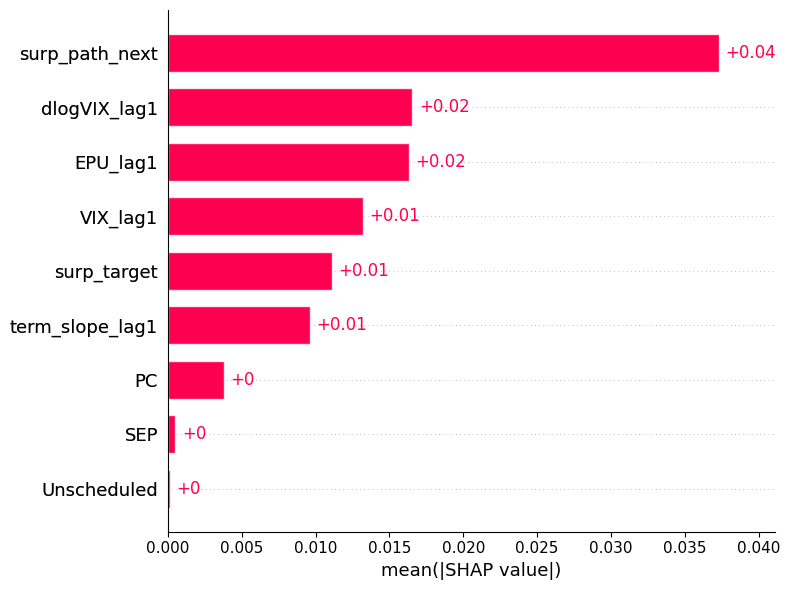

Saved: c:\Users\starw\.vscode\practice\outputs\Figure1_SHAP_bar.png


,feature,mean_abs_shap
1,surp_path_next,0.037311
6,dlogVIX_lag1,0.016552
7,EPU_lag1,0.016313
5,VIX_lag1,0.013214
0,surp_target,0.011083
8,term_slope_lag1,0.009620
3,PC,0.003802
4,SEP,0.000511
2,Unscheduled,0.000150


In [26]:
# Cell 9: XGBoost + SHAP (interpretation only) + save Figure 1

# Build feature list based on what's actually available in ev
feature_cols = [
    "surp_target","surp_path_next",
    "Unscheduled","PC","SEP",
    "VIX_lag1","dlogVIX_lag1","EPU_lag1","term_slope_lag1"
]

# Add optional columns if they exist
if "surp_path_ffavg" in ev.columns and ev["surp_path_ffavg"].notna().any():
    feature_cols.append("surp_path_ffavg")
if "ADS_lag1" in ev.columns and ev["ADS_lag1"].notna().any():
    feature_cols.append("ADS_lag1")

print("Features for XGBoost:", feature_cols)

ev_ml = ev.copy()
X = ev_ml[feature_cols].copy()
y_shap = ev_ml["dlogVIX"].copy()

xgb = XGBRegressor(
    n_estimators=700,
    max_depth=2,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=8.0,
    random_state=42
)
xgb.fit(X, y_shap)

explainer = shap.Explainer(xgb, X)
sv = explainer(X)

# Save SHAP bar as Figure 1
fig_path = OUTPUTS / "Figure1_SHAP_bar.png"
plt.figure(figsize=(7,5))
shap.plots.bar(sv, max_display=12, show=False)
plt.tight_layout()
plt.savefig(fig_path, dpi=300, bbox_inches="tight")
plt.show()

# SHAP importance table
mean_abs = np.abs(sv.values).mean(axis=0)
shap_rank = pd.DataFrame({"feature": X.columns, "mean_abs_shap": mean_abs}).sort_values("mean_abs_shap", ascending=False)
shap_rank.to_csv(OUTPUTS / "shap_importance_eventdays.csv", index=False)

print("Saved:", fig_path)
display(shap_rank.head(15))

In [31]:
# Cell 10: Build Table 1 (LaTeX) using HC1 + (correct) wild bootstrap under NULL
# NOTE: Uses robust_inf generated in Cell 7 (WB_null_p).

# Grab main coefficients
keys = ["surp_target","surp_path_next","VIX_lag1","EPU_lag1","ADS_lag1","term_slope_lag1"]
main_tbl = coef_table(m_main, keys)

# Merge bootstrap p-values (NULL) into the two shocks
wb_map = robust_inf.set_index("var")["WB_null_p"].to_dict()
main_tbl["p_wild_bootstrap_NULL"] = main_tbl["var"].map(wb_map)

# Format for LaTeX
def p_fmt(x, B=9999):
    if pd.isna(x):
        return ""
    if x == 0:
        return f"<{1/B:.4f}"
    if x < 0.001:
        return "<0.001"
    return f"{x:.3f}"

def num_fmt(x):
    if pd.isna(x):
        return ""
    return f"{x:.3f}"

fmt = main_tbl.copy()
fmt["coef"] = fmt["coef"].map(num_fmt)
fmt["se"]   = fmt["se"].map(num_fmt)
fmt["t"]    = fmt["t"].map(num_fmt)
fmt["p"]    = fmt["p"].map(lambda x: f"{x:.3f}" if pd.notna(x) else "")

# 여기 핵심
fmt["p_wild_bootstrap_NULL"] = fmt["p_wild_bootstrap_NULL"].map(lambda x: p_fmt(x, B=9999))

latex_path = OUTPUTS / "Table1_MAIN.tex"
with open(latex_path, "w", encoding="utf-8") as f:
    f.write(fmt.to_latex(index=False))

print("Saved LaTeX Table 1:", latex_path)
display(fmt)

Saved LaTeX Table 1: c:\Users\starw\.vscode\practice\outputs\Table1_MAIN.tex


,var,coef,se,t,p,p_wild_bootstrap_NULL
0,surp_target,-0.516,0.667,-0.774,0.439,0.520
1,surp_path_next,1.449,0.513,2.823,0.005,<0.001
2,VIX_lag1,-0.000,0.001,-0.455,0.649,
3,EPU_lag1,-0.000,0.000,-0.949,0.343,
4,term_slope_lag1,-0.003,0.020,-0.137,0.891,


In [32]:
# Cell 11 (LAST): Collect everything to paste into ChatGPT

print("="*80)
print("A) Table 1 (LaTeX) - paste this whole block")
print("="*80)

table_tex = (OUTPUTS / "Table1_MAIN.tex").read_text(encoding="utf-8")
print(table_tex)

print("\n" + "="*80)
print("B) Figure 1 path (upload this PNG or screenshot it)")
print("="*80)

fig_path = OUTPUTS / "Figure1_SHAP_bar.png"
print("Figure1_SHAP_bar.png saved at:", fig_path)

print("\n" + "="*80)
print("C) dlogVIX one-line definition (paste into Methods)")
print("="*80)

dlog_line = 'panel["dlogVIX"] = np.log(panel["VIX"]).diff()'
print(dlog_line)

print("\n" + "="*80)
print("D) Snapshot JSON (copy this entire JSON to ChatGPT)")
print("="*80)

# Minimal snapshot for writing
snapshot = {
    "sample_period": [str(panel.index.min().date()), str(panel.index.max().date())],
    "n_obs_panel": int(len(panel)),
    "n_event_days": int(panel["is_event"].sum()),
    "Table1_rows": main_tbl.to_dict(orient="records"),
    "Robust_inference_summary": robust_inf.to_dict(orient="records"),
    "Robust_path_ffavg": (pd.read_csv(OUTPUTS / "robust_path_ffavg_keycoef.csv").to_dict(orient="records")
                          if (OUTPUTS / "robust_path_ffavg_keycoef.csv").exists() else None),
    "Robust_add_spret": pd.read_csv(OUTPUTS / "robust_add_spret_keycoef.csv").to_dict(orient="records"),
    "Robust_interaction_unsched": pd.read_csv(OUTPUTS / "robust_interaction_unsched_keycoef.csv").to_dict(orient="records"),
    "Top15_SHAP_eventdays": shap_rank.head(15).to_dict(orient="records"),
    "notes": {
        "VIX_source": "FRED VIXCLS (Cboe VIX via FRED)",
        "dlogVIX_definition": dlog_line,
        "baseline": "Event-day regression with both target and path surprises + lagged state controls",
        "inference": "HC1 + studentized wild bootstrap under NULL + unrestricted + permutation",
        "shap_usage": "Interpretation only (no forecasting claims)"
    }
}

snap_path = OUTPUTS / "results_snapshot_FINAL_for_writeup.json"
snap_path.write_text(json.dumps(snapshot, indent=2), encoding="utf-8")
print(json.dumps(snapshot, indent=2))

print("\nSaved snapshot to:", snap_path)


A) Table 1 (LaTeX) - paste this whole block
\begin{tabular}{llllll}
\toprule
var & coef & se & t & p & p_wild_bootstrap_NULL \\
\midrule
surp_target & -0.516 & 0.667 & -0.774 & 0.439 & 0.520 \\
surp_path_next & 1.449 & 0.513 & 2.823 & 0.005 & <0.001 \\
VIX_lag1 & -0.000 & 0.001 & -0.455 & 0.649 &  \\
EPU_lag1 & -0.000 & 0.000 & -0.949 & 0.343 &  \\
term_slope_lag1 & -0.003 & 0.020 & -0.137 & 0.891 &  \\
\bottomrule
\end{tabular}


B) Figure 1 path (upload this PNG or screenshot it)
Figure1_SHAP_bar.png saved at: c:\Users\starw\.vscode\practice\outputs\Figure1_SHAP_bar.png

C) dlogVIX one-line definition (paste into Methods)
panel["dlogVIX"] = np.log(panel["VIX"]).diff()

D) Snapshot JSON (copy this entire JSON to ChatGPT)
{
  "sample_period": [
    "2010-01-01",
    "2025-12-28"
  ],
  "n_obs_panel": 5841,
  "n_event_days": 135,
  "Table1_rows": [
    {
      "var": "surp_target",
      "coef": -0.515972777438296,
      "se": 0.6670046359938537,
      "t": -0.773567003277996,
      "p"

In [33]:
# Cell 12: Appendix Table A1 (Inference Robustness) LaTeX

app = robust_inf.copy()

# prettier formatting
def pf(x):
    if pd.isna(x): return ""
    if x < 0.001:  return "<0.001"
    return f"{x:.3f}"

def nf(x):
    if pd.isna(x): return ""
    return f"{x:.3f}"

app2 = pd.DataFrame({
    "var": app["var"],
    "HC1_p": app["HC1_p"].map(pf),
    "WB_null_p": app["WB_null_p"].map(pf),
    "WB_unrestricted_p": app["WB_unrestricted_p"].map(pf),
    "Permutation_p": app["Perm_p"].map(pf),
})

latex_a1 = OUTPUTS / "TableA1_InferenceRobustness.tex"
latex_a1.write_text(app2.to_latex(index=False), encoding="utf-8")
print("Saved:", latex_a1)
print(app2)


Saved: c:\Users\starw\.vscode\practice\outputs\TableA1_InferenceRobustness.tex
              var  HC1_p WB_null_p WB_unrestricted_p Permutation_p
0  surp_path_next  0.005    <0.001             0.533         0.003
1     surp_target  0.439     0.520             0.596         0.305
